Install packages

In [ ]:
%%capture
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

import libraries

In [ ]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

The console stream is logged into /root/sg_logs/console.log


[2023-06-16 12:21:11] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-06-16 12:21:17] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-06-16 12:21:17] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-06-16 12:21:17] WARNING - export.py - Failed to import pytorch_quantization
[2023-06-16 12:21:17] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [ ]:
from IPython.display import clear_output

In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

In [ ]:
from super_gradients.training import models

Setting the checkpoint directory

In [ ]:
CHECKPOINT_DIR='checkpoints'
trainer= Trainer(experiment_name='anpr_yolonas_run',ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:


from roboflow import Roboflow
rf = Roboflow(api_key="Guvpdq5Ubgl64dzBXaiF")
project = rf.workspace("moin").project("car_license_plates")
dataset = project.version(2).download("yolov5")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Car_License_Plates-2 in yolov5pytorch:: 100%|██████████| 1436/1436 [00:00<00:00, 3935.69it/s]


step5: load dataset parameters to dic

In [ ]:
dataset_params={
    'data_dir':'/content/Car_License_Plates-2',
    'train_images_dir':'/content/Car_License_Plates-2/train/images',
    'train_labels_dir':'/content/Car_License_Plates-2/train/labels',
    'val_images_dir':'/content/Car_License_Plates-2/valid/images',
    'val_labels_dir':'/content/Car_License_Plates-2/valid/labels',
    'test_images_dir':'/content/Car_License_Plates-2/test/images',
    'train_labels_dir':'/content/Car_License_Plates-2/train/labels',
    'classes':['licence']
}

pass the value for dataset params

In [ ]:
train_data=coco_detection_yolo_format_train(
    dataset_params={
        'data_dir':dataset_params['data_dir'],
        'images_dir':dataset_params['train_images_dir'],
        'labels_dir':dataset_params['train_labels_dir'],
        'classes':dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data=coco_detection_yolo_format_val(
    dataset_params={
        'data_dir':dataset_params['data_dir'],
        'images_dir':dataset_params['train_images_dir'],
        'labels_dir':dataset_params['train_labels_dir'],
        'classes':dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)
clear_output()

Caching annotations: 100%|██████████| 618/618 [00:00<00:00, 6089.93it/s]


**7.inspect dataset**

In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

In [ ]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [ ]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees']=10.42

8. checking data

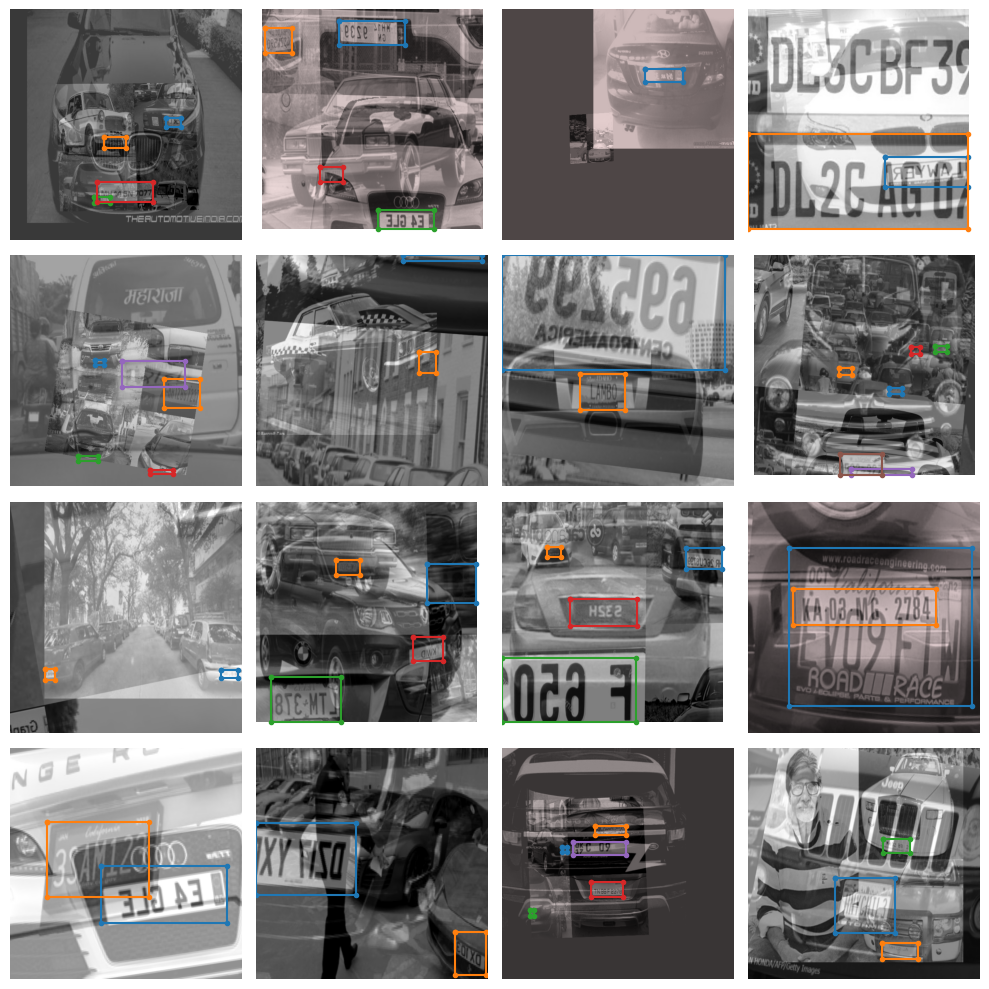

In [ ]:
train_data.dataset.plot()

s9: instantiating the model

In [ ]:
 model =models.get('yolo_nas_s',
                  num_classes=len(dataset_params['classes']),
                  pretrained_weights='coco'
                  )

[2023-06-16 12:22:42] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


  0%|          | 0.00/73.1M [00:00<?, ?B/s]

Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth


10. define metrics and training parameters

In [ ]:
from torch import threshold
train_params = {
    'silent_mode': True,
    'average_best_models': True,
    'warmup_mode':'linear_epoch_step',
    "warmup_mode" : "linear_epoch_step",
    'warmup_initial_lr' : 1e-6,
    'lr_warmup_epochs': 3,
    'initial_lr' : 5e-4,
    'lr_mode': 'cosine',
    'cosine_final_ratio':0.1,
    'optimizer':'Adam',
    'optimizer_params':{'weight_decay':0.0001},
    'zero_weight_decay_on_basis_and_bn': True,
    'ema':True,
    'ema_params':{'decay':0.9,'decay_type':'threshold'},
    #only training for 10 epochs for this sample notebook
    'max_epochs':15,
    'mixed_precision':True,
    'loss':PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    'valid_metrics_list':[
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.1,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )

        )
    ],
    'metric_to_watch':'mAP@0.50'

}


Train


In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2023-06-16 12:40:36] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/anpr_yolonas_run/console_Jun16_12_40_41.txt


[2023-06-16 12:40:48] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 617        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         38         (len(train_loader))
    - Gradient updates per epoch:   38         (len(train_loader) / batch_accumulate)

[2023-06-16 12:41:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/anpr_yolonas_run/ckpt_best.pth
[2023-06-16 12:41:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.0
[2023-06-16 12:42:53] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/anpr_yolon

SUMMARY OF EPOCH 15
├── Training
│   ├── Ppyoloeloss/loss = 1.8291
│   │   ├── Best until now = 1.8408 (↘ -0.0117)
│   │   └── Epoch N-1      = 1.8408 (↘ -0.0117)
│   ├── Ppyoloeloss/loss_cls = 0.8774
│   │   ├── Best until now = 0.8814 (↘ -0.004)
│   │   └── Epoch N-1      = 0.8814 (↘ -0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.9558
│   │   ├── Best until now = 0.9623 (↘ -0.0065)
│   │   └── Epoch N-1      = 0.9623 (↘ -0.0065)
│   └── Ppyoloeloss/loss_iou = 0.1895
│       ├── Best until now = 0.1913 (↘ -0.0018)
│       └── Epoch N-1      = 0.1913 (↘ -0.0018)
└── Validation
    ├── F1@0.50 = 0.0865
    │   ├── Best until now = 0.0929 (↘ -0.0064)
    │   └── Epoch N-1      = 0.0777 (↗ 0.0088)
    ├── Map@0.50 = 0.915
    │   ├── Best until now = 0.9321 (↘ -0.0171)
    │   └── Epoch N-1      = 0.9276 (↘ -0.0126)
    ├── Ppyoloeloss/loss = 1.7124
    │   ├── Best until now = 1.6682 (↗ 0.0442)
    │   └── Epoch N-1      = 1.6769 (↗ 0.0356)
    ├── Ppyoloeloss/loss_cls = 0.8401
    │   ├── Bes

In [ ]:
best_model=models.get('yolo_nas_s',
                      num_classes=len(dataset_params['classes']),
                      checkpoint_path='/content/drive/MyDrive/anpr_yolonas_run/ckpt_best.pth')

[2023-06-16 12:23:24] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/anpr_yolonas_run/ckpt_best.pth EMA checkpoint.


picture predict

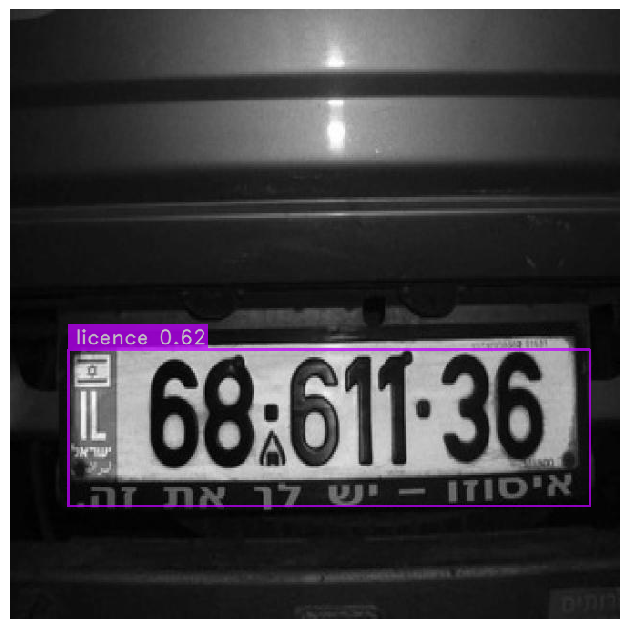

In [ ]:
#predict
img='/content/Car_License_Plates-2/test/images/Cars102_png.rf.fb7edb268f3d11a61f7ed08bd6e54de0.jpg'
best_model.predict(img).show()

Testing on video

In [ ]:
input_video_path=f'/content/sample_video - Made with Clipchamp.mp4'
output_video_path='detection.mp4'

In [ ]:
import torch
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
best_model.to(device).predict(input_video_path).save(output_video_path)

Predicting Video: 100%|██████████| 657/657 [00:23<00:00, 27.93it/s]
